# Proyecto_2_Deraining_CycleGAN

### Héctor César Ornelas León

Link al repositorio:

## Introducción

El objetivo de este proyecto es desarrollar y evaluar un modelo de red generativa adversaria (GAN), específicamente un CycleGAN, para la tarea de eliminar la lluvia de imágenes fotográficas. Utilizando TensorFlow y su biblioteca de ejemplos, entrenaremos un modelo para transformar imágenes con lluvia en imágenes sin lluvia, permitiendo así una mejora visual significativa en condiciones meteorológicas adversas. Además, evaluaremos la calidad de las imágenes generadas mediante el Índice de Similitud Estructural (SSIM), una métrica que compara la percepción de calidad entre dos imágenes.

## Descripción del método (CycleGAN)

CycleGAN es un tipo de red generativa adversaria (GAN) que permite la traducción de imágenes de un dominio a otro sin necesidad de emparejamiento supervisado entre las imágenes de entrenamiento. Este modelo fue presentado en un trabajo de 2017 por Jun-Yan Zhu, Taesung Park, Phillip Isola y Alexei A. Efros. CycleGAN se destaca por su capacidad para aprender a transformar imágenes de un estilo a otro mediante el aprendizaje de mapeos de características entre dos dominios no emparejados.

El modelo utiliza dos GANs configurados en un ciclo: uno que traduce del dominio A al dominio B, y otro que traduce de vuelta del dominio B al dominio A. Esto se complementa con una función de pérdida de ciclo que penaliza las inconsistencias en estas traducciones para fomentar la preservación del contenido mientras se cambia el estilo. El ciclo completo ayuda a asegurar que la entrada original pueda ser reconstruida después de una doble traducción (A a B, y luego B a A), lo que refuerza que las transformaciones aprendidas mantengan coherencia y no pierdan características críticas del dominio original.

## Objetivo

En este caso, nos centraremos exclusivamente en visualizar las imágenes generadas sin lluvia. Será con el objetivo de eliminar características de lluvia, más allá de la simple mejora visual, contribuyendo significativamente a aplicaciones críticas en seguridad y accesibilidad. En particular, este proyecto puede dirigirse a mejorar la claridad y la visibilidad en sistemas de videovigilancia y asistencia a la conducción, especialmente bajo condiciones meteorológicas adversas.



## Desarrollo del Código

1. Configuración e Importaciones.

Primero, importamos las librerías necesarias y configuramos parámetros globales.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-1n70ftwr
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-1n70ftwr
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras import layers
from tensorflow.image import ssim
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

2. Preprocesamiento y carga de datos

Definimos las funciones para cargar y preprocesar las imágenes tanto de entrenamiento como de prueba y después cargamos los conjuntos de datos.

## Descripción del dataset

Este dataset contiene imágenes con lluvia generada artificialmente. Se cuenta con 1000 pares de imágenes con lluvia y sin lluvia. 900 de estos de pares de imágenes han sido utilizadas para el set de entrenamiento y los 100 restantes para el set de pruebas.

In [ ]:
path_to_rain = '/content/drive/MyDrive/Proyecto_2_DL/rain_dataset/rain_img_train'
path_to_norain = '/content/drive/MyDrive/Proyecto_2_DL/rain_dataset/no_rain_img_train'
path_to_test_rain = '/content/drive/MyDrive/Proyecto_2_DL/rain_dataset/rain_img_test'
path_to_test_norain = '/content/drive/MyDrive/Proyecto_2_DL/rain_dataset/no_rain_img_test'


def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    input_image = tf.cast(image, tf.float32)
    return input_image

def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def random_crop(input_image):
    cropped_image = tf.image.random_crop(input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

# Normalizing the images to [-1, 1]
def normalize(input_image):
    input_image = (input_image / 127.5) - 1
    return input_image

@tf.function()
def random_jitter(input_image):
    # resizing to 286 x 286 x 3
    input_image = resize(input_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image = random_crop(input_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)

    return input_image

def preprocess_image_train(image_file):
    input_image = load(image_file)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)
    return input_image

def preprocess_image_test(image_file):
    input_image = load(image_file)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    input_image = normalize(input_image)
    return input_image

train_rain = tf.data.Dataset.list_files(path_to_rain + '/*.jpg', shuffle=True)
train_rain = train_rain.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_norain = tf.data.Dataset.list_files(path_to_norain + '/*.jpg', shuffle=True)
train_norain = train_norain.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_rain_dataset = tf.data.Dataset.list_files(path_to_test_rain + '/*.jpg', shuffle=False)
test_rain_dataset = test_rain_dataset.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

test_norain_dataset = tf.data.Dataset.list_files(path_to_test_norain + '/*.jpg', shuffle=False)
test_norain_dataset = test_norain_dataset.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.zip((test_rain_dataset, test_norain_dataset))

3. Definición del Modelo

Configuramos el modelo CycleGAN utilizando la arquitectura U-Net proporcionada por tensorflow_examples.

El modelo CycleGAN utiliza una arquitectura de red conocida como U-Net para sus generadores.

Características de la Arquitectura U-Net:

- Estructura en Forma de U: Como su nombre indica, U-Net tiene una estructura en forma de U que consta de un camino de contracción (codificador) y un camino de expansión (decodificador).

- Estructura Simétrica en Forma de U: La arquitectura se caracteriza por su forma simétrica en 'U', que consta de un camino de contracción (encogimiento) y un camino de expansión (dilatación). Esto permite a la red capturar contextos a diferentes escalas y realizar una segmentación precisa.

- Camino de Contracción (Codificador):Consiste en la repetición de bloques de dos capas convolucionales seguidas de una operación de max-pooling para la reducción de dimensiones.
Cada capa convolucional en el codificador típicamente sigue con una función de activación ReLU y una normalización por lotes.
Este camino se encarga de capturar las características y contextos de la imagen, reduciendo progresivamente las dimensiones espaciales mientras aumenta la profundidad de características.

- Camino de Expansión (Decodificador): Incluye capas de convolución y operaciones de upsampling que incrementan gradualmente las dimensiones espaciales de las características mientras reducen la profundidad.
En cada paso de upsampling, se realiza una concatenación con las características correspondientes del camino de contracción a través de conexiones de salto. Esto es crucial para incorporar contextos locales y globales en la segmentación.
Las conexiones de salto ayudan a recuperar la información espacial que puede perderse durante el max-pooling.

- Conexiones de Salto: Son elementos críticos en U-Net, permitiendo la transferencia directa de información de características desde el camino de contracción al camino de expansión.
Estas conexiones ayudan a preservar los detalles importantes necesarios para una segmentación precisa, fusionando características de baja y alta resolución.

- Capa Final: La salida del camino de expansión pasa por una última capa convolucional que ajusta el número de canales de salida al número de clases deseadas en la tarea de segmentación.
Comúnmente, se utiliza una función de activación como la sigmoidal o softmax para clasificar cada píxel en una de las clases.

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                          generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                              discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))


4. Descripción del Proceso de Entrenamiento

- Iniciación de tf.GradientTape: Se utiliza para registrar operaciones para la diferenciación automática. persistent=True permite múltiples llamadas a gradient() dentro del mismo contexto, lo cual es necesario para calcular los gradientes tanto para los generadores como para los discriminadores.

- Transformaciones del Generador:
Generación de Imágenes Falsas: generator_g traduce imágenes de real_x a fake_y (por ejemplo, de con lluvia a sin lluvia), y generator_f hace lo inverso.
Ciclo de Imágenes: Para asegurar que las imágenes puedan ser traducidas de vuelta a su forma original, fake_y es pasado a través de generator_f para obtener cycled_x, y viceversa para fake_x a cycled_y.
Pérdida de Identidad: same_x y same_y se generan pasando real_x y real_y a través de generator_f y generator_g, respectivamente, sin alterar su dominio, para preservar la identidad a través de las transformaciones.
Evaluación del Discriminador:

- Discriminadores en Imágenes Reales y Falsas: Se evalúa si los discriminadores discriminator_x y discriminator_y pueden distinguir entre imágenes reales (real_x, real_y) e imágenes generadas (fake_x, fake_y).
Cálculo de Pérdidas:

- Pérdida del Generador: Incluye la pérdida adversaria (qué tan bien las imágenes generadas engañan al discriminador) y la pérdida de ciclo (qué tan cerca están las imágenes cíclicas de ser idénticas a las imágenes originales).
Pérdida del Discriminador: Evalúa qué tan bien los discriminadores distinguen entre imágenes reales y generadas.
Cálculo de Gradientes y Actualización de Parámetros:

- Cálculo de Gradientes: Se usan las pérdidas para calcular los gradientes de las variables entrenables de los generadores y discriminadores.
Aplicación de Gradientes: Los gradientes son aplicados usando optimizadores específicos para cada conjunto de variables del modelo, ajustando así los pesos para minimizar las pérdidas.

In [ ]:
import time
from IPython.display import clear_output

# Direcciones para guardar los checkpoints
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Si existe un checkpoint, restaura el último checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Último checkpoint restaurado!!')


Último checkpoint restaurado!!


In [ ]:
def generate_images_and_calculate_ssim(model, test_input, test_target):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 5))

    display_list = [test_input[0], prediction[0], test_target[0]]
    title = ['Imagen con Lluvia', 'Imagen Generada', 'Imagen sin Lluvia']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

    # Calcular SSIM
    ssim_value = ssim(test_target, prediction + 1, max_val=2.0)
    print(f"SSIM: {ssim_value.numpy().mean():.3f}")



**Ciclo de entrenamiento del modelo**

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_rain, train_norain)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n+=1

    clear_output(wait=True)

    for test_input, test_target in test_dataset.take(1):
        generate_images_and_calculate_ssim(generator_g, test_input, test_target)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Guardando checkpoint en la época {epoch+1} en el path {ckpt_save_path}')

    print(f'Época {epoch+1} completada en {time.time()-start:.2f} segundos')



El modelo ha sido entrenado con 20 épocas. Durante cada época, itera sobre un conjunto de datos emparejados de imágenes con lluvia (train_rain) y sin lluvia (train_norain), utilizando la función train_step para actualizar los pesos del modelo.

Se evalúa el modelo en cada época utilizando un subconjunto del conjunto de datos de prueba para generar imágenes y calcular el SSIM, lo cual proporciona una medida cuantitativa de la similitud entre las imágenes generadas y las imágenes objetivo sin lluvia. Finalmente, guarda checkpoints del modelo cada cinco épocas para permitir la recuperación del entrenamiento y concluye con una impresión del tiempo que tomó completar cada época, ofreciendo así una visión detallada del rendimiento y la eficiencia del entrenamiento.

**Pruebas**

El código itera sobre los primeros 10 pares de imágenes del conjunto de datos de prueba, utilizando cada par compuesto por una imagen con lluvia (test_input) y su correspondiente sin lluvia (test_target), para generar imágenes transformadas con el modelo generator_g y calcular el Índice de Similitud Estructural (SSIM) entre las imágenes generadas y las objetivo. Este proceso evalúa cuantitativa y visualmente la capacidad del modelo CycleGAN para eliminar características de lluvia en imágenes, proporcionando una medida directa de su eficacia y precisión.

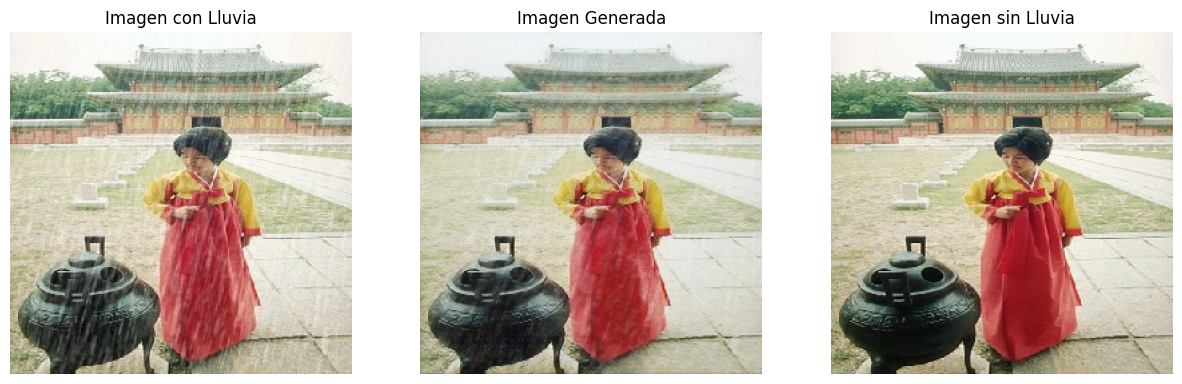

SSIM: 0.191


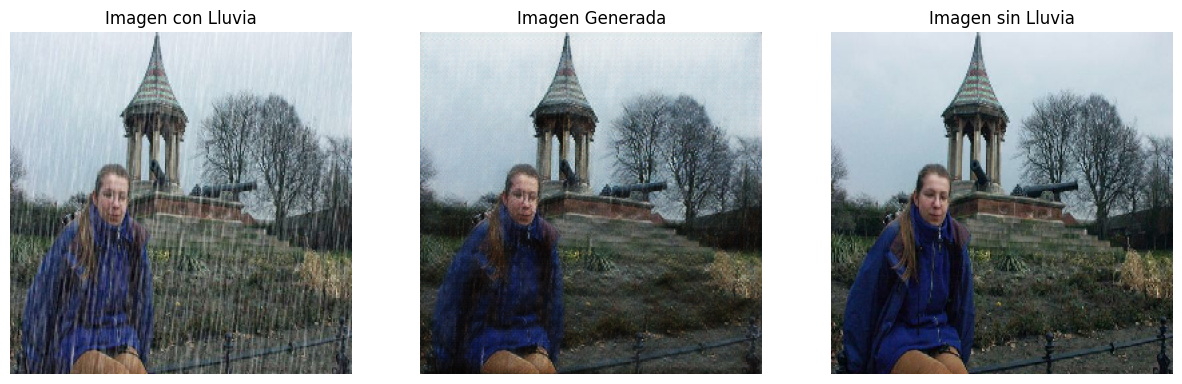

SSIM: -0.174


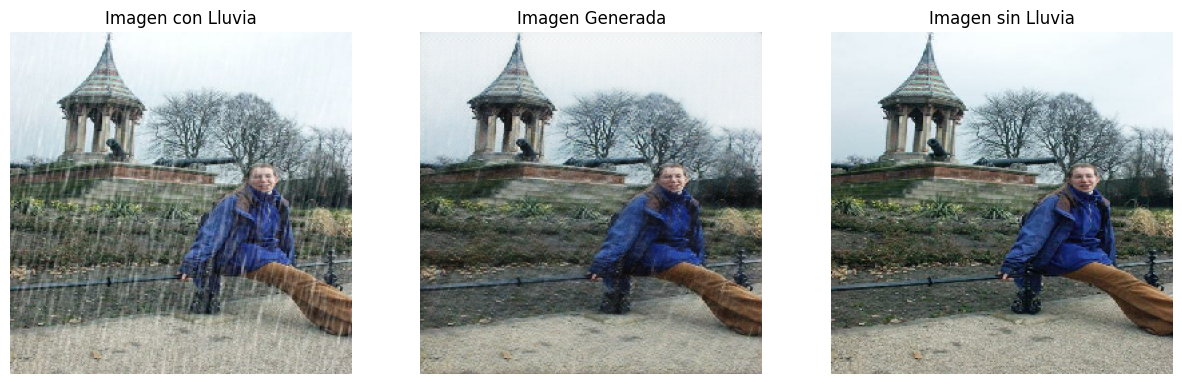

SSIM: -0.078


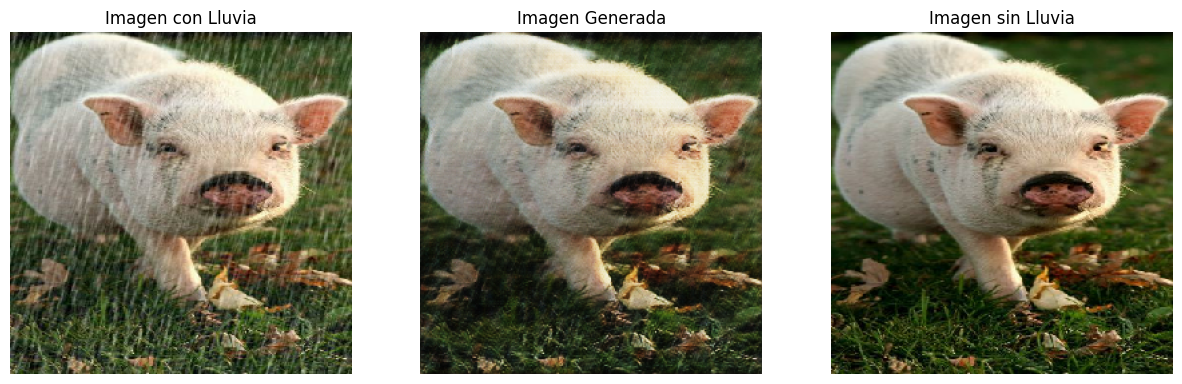

SSIM: -0.198


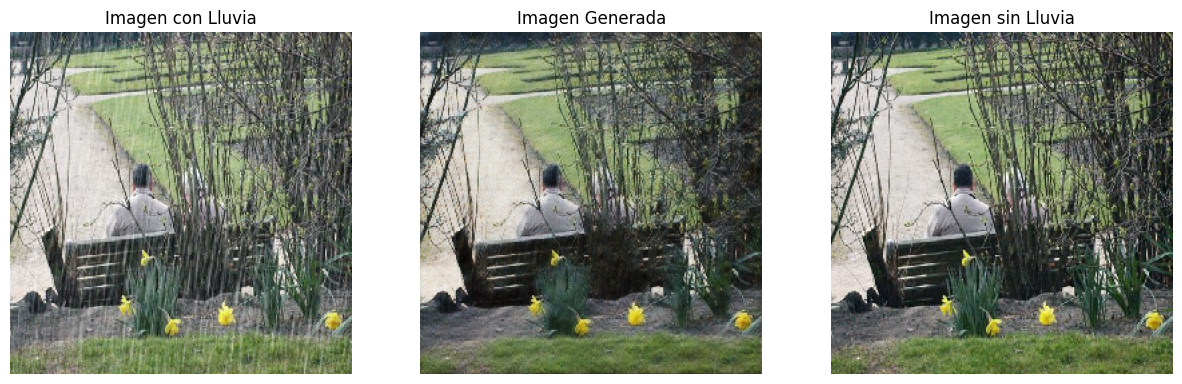

SSIM: -0.266


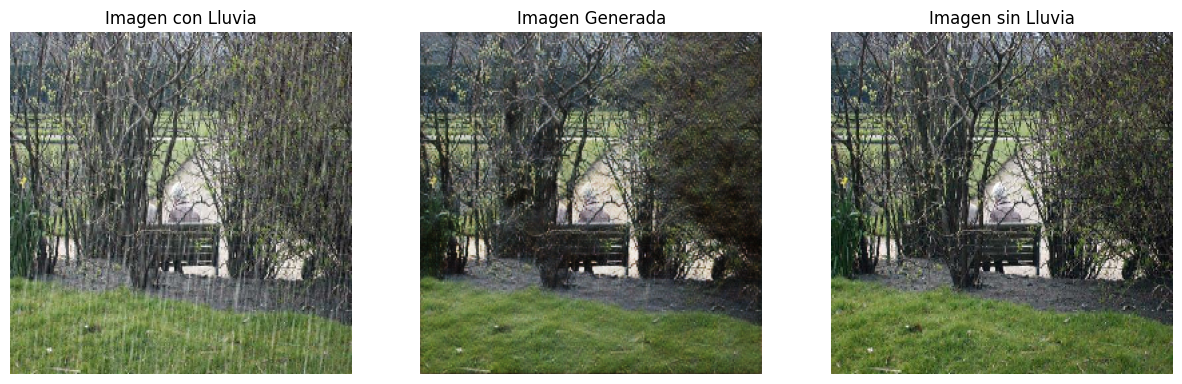

SSIM: -0.492


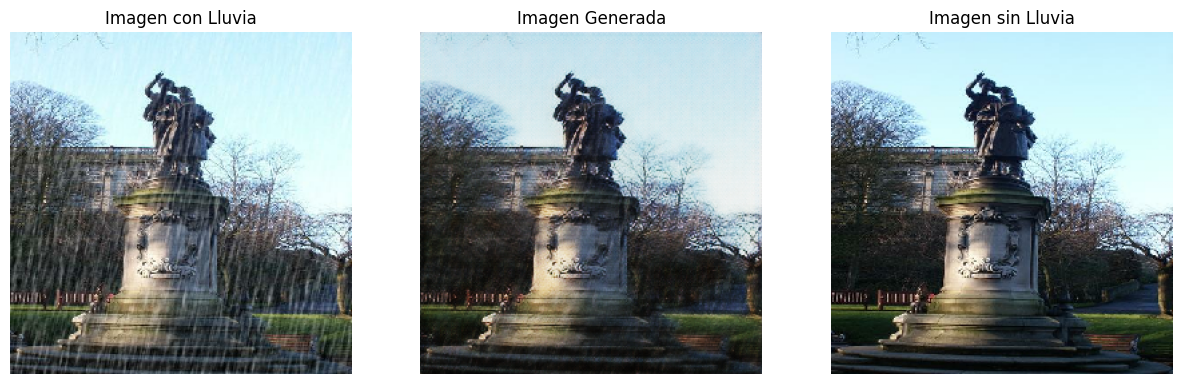

SSIM: -0.049


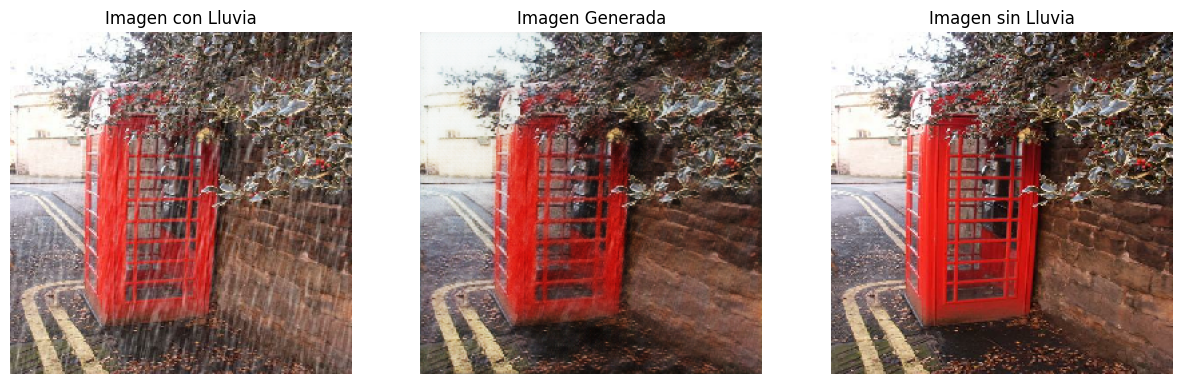

SSIM: -0.260


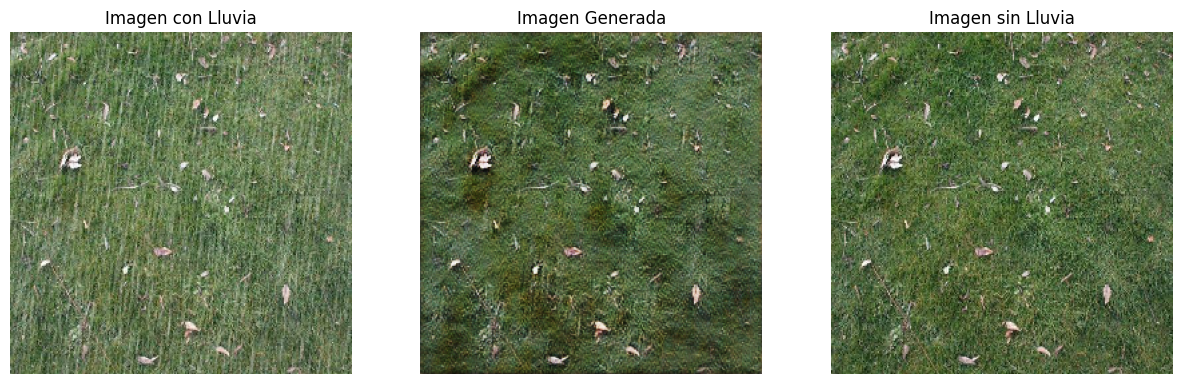

SSIM: -0.530


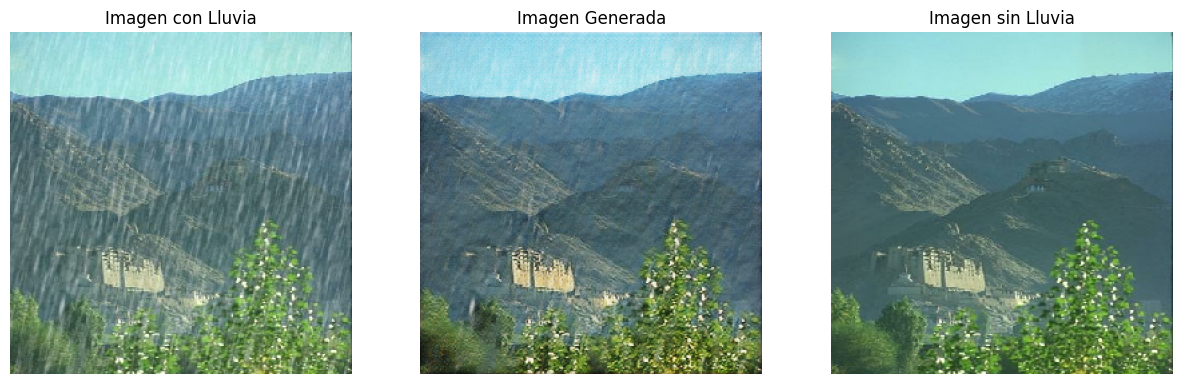

SSIM: -0.214


In [ ]:
for test_input, test_target in test_dataset.take(10):
    generate_images_and_calculate_ssim(generator_g, test_input, test_target)

## Resultados

La evaluación del modelo CycleGAN utilizando el Índice de Similitud Estructural (SSIM) no proporcionó los resultados esperados, lo cual podría deberse a varias causas. Primero, el SSIM puede ser sensible a variaciones de textura y luz en las imágenes que no afectan significativamente la percepción visual humana de la calidad o el contenido. Esto significa que pequeñas discrepancias entre las imágenes generadas y las imágenes objetivo, como diferencias en iluminación o en detalles finos, podrían resultar en valores bajos de SSIM aun cuando las imágenes generadas parezcan visualmente satisfactorias.

A pesar de estos resultados cuantitativos más bajos de lo esperado, la evaluación visual indica que el modelo realiza un trabajo aceptable al eliminar la lluvia de las imágenes. Esto sugiere que, aunque el SSIM no refleje completamente la eficacia del modelo debido a su sensibilidad a factores que no degradan significativamente la calidad visual, el modelo logra su objetivo principal de manera efectiva. Visualmente, las imágenes resultantes muestran una clara reducción de la lluvia, mejorando la claridad y la visibilidad, lo que indica que el modelo puede ser muy útil en aplicaciones prácticas donde la percepción visual humana es más relevante que las métricas de similitud estrictas.








## Trabajos futuros

Para trabajos futuros, sería beneficioso explorar el ajuste fino y la optimización de la arquitectura CycleGAN para mejorar la precisión cuantitativa del modelo, particularmente en términos del Índice de Similitud Estructural (SSIM). Esto podría incluir experimentar con diferentes métodos de normalización y ajustes en la estructura de la red. Además, la aplicación de técnicas avanzadas de aprendizaje profundo como el aprendizaje de transferencia o el uso de redes más profundas o especializadas podría mejorar la capacidad del modelo para manejar una variedad más amplia de condiciones de lluvia y otros tipos de degradaciones visuales.

## Conclusión

En conclusión, este proyecto ha demostrado cómo implementar y entrenar un modelo CycleGAN utilizando la arquitectura U-Net para abordar el desafío de eliminar visualmente la lluvia de las imágenes. Aunque el Índice de Similitud Estructural (SSIM) no proporcionó valores tan altos como se esperaba, lo que podría atribuirse a la sensibilidad de la métrica a variaciones sutiles en las imágenes que no afectan significativamente la percepción humana, la evaluación visual confirmó que el modelo es efectivamente capaz de mejorar la claridad de las imágenes al reducir o eliminar las características de lluvia. Este resultado es prometedor, ya que indica que el modelo puede ser muy útil en aplicaciones prácticas donde la calidad visual es crucial, como en la mejora de imágenes para análisis visual o en aplicaciones de videovigilancia y conducción autónoma bajo condiciones meteorológicas adversas.